In [1]:
import uproot
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

In [62]:
tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/minirun6_caf_outputs/2p2h_reco_output_1.4.root")
tracks["RecoTree"].show()
tracks["RecoTree"].keys()

branches = tracks["RecoTree"].arrays()[0]
file_index = np.array((branches['file_index'])) #DO NOT CHANGE THIS LINE
file_index_unique = np.unique(file_index)
print("File indeces: ", file_index_unique) #DO NOT CHANGE THIS LINE

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

File #:  27
Event #:  [152] 

Number of reco protons in event =  3
Number of truth protons in event =  7
truth_ixn.nprotons =  [2 2 2 2 2 2 2 2 2 2 2 2 2]
Number of reco pions in event =  2
Number of truth pions in event =  0 



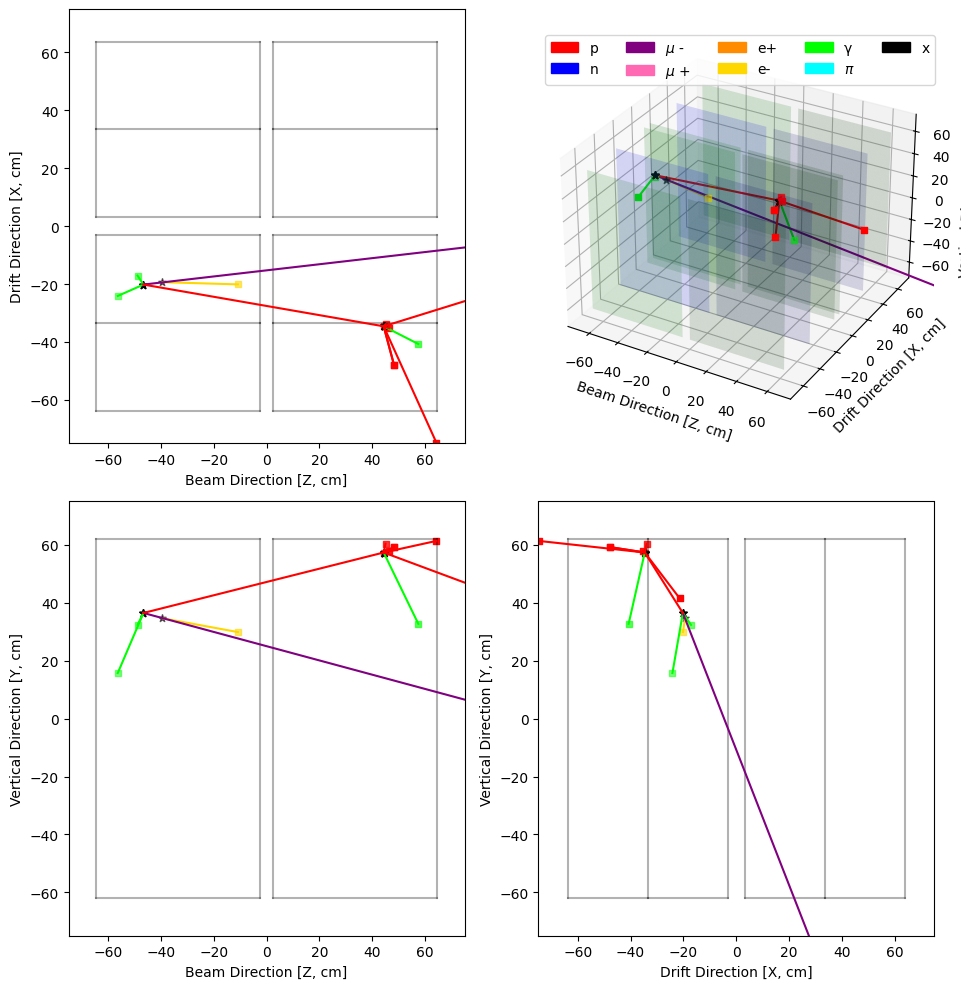

In [63]:
file_idx = 27

true_energy = branches['true_energy'][file_index == file_idx]
true_p_x = branches['true_p_x'][file_index == file_idx]
true_p_y = branches['true_p_y'][file_index == file_idx]
true_p_z = branches['true_p_z'][file_index == file_idx]
true_p_mag = branches['true_p_mag'][file_index == file_idx]
true_length = branches['true_length'][file_index == file_idx]
true_angle = branches['true_angle'][file_index == file_idx]
true_angle_rot = branches['true_angle_rot'][file_index == file_idx]
true_angle_incl = branches['true_angle_incl'][file_index == file_idx]
true_angle_x = branches['true_angle_x'][file_index == file_idx]
true_angle_y = branches['true_angle_y'][file_index == file_idx]
true_angle_z = branches['true_angle_z'][file_index == file_idx]
true_track_start_x = branches['true_track_start_x'][file_index == file_idx]
true_track_start_y = branches['true_track_start_y'][file_index == file_idx]
true_track_start_z = branches['true_track_start_z'][file_index == file_idx]
true_track_end_x = branches['true_track_end_x'][file_index == file_idx]
true_track_end_y = branches['true_track_end_y'][file_index == file_idx]
true_track_end_z = branches['true_track_end_z'][file_index == file_idx]
true_pdg = branches['true_pdg'][file_index == file_idx]
true_nproton = branches['true_nproton'][file_index == file_idx]

reco_pdg = branches['reco_pdg'][file_index == file_idx]
reco_energy = branches['reco_energy'][file_index == file_idx]
reco_p_x = branches['reco_p_x'][file_index == file_idx]
reco_p_y = branches['reco_p_y'][file_index == file_idx]
reco_p_z = branches['reco_p_z'][file_index == file_idx]
reco_p_mag = branches['reco_p_mag'][file_index == file_idx]

spill_index = branches['spill_index'][file_index == file_idx]
event = np.array(branches['event'][file_index == file_idx])
run = branches['run'][file_index == file_idx]
subrun = branches['subrun'][file_index == file_idx]
caf_file_name = branches['caf_file_name'][file_index == file_idx]

file_name = caf_file_name[0]
name_split = file_name.split(".")
file_num = int(name_split[2]) #Reco
#file_num = int(name_split[4]) #Truth
print("File #: ", file_num)
print("Event #: ", np.unique(event), "\n")

unique_event = np.unique(event)

for ev in unique_event:
    true_start_x_ev = np.array(true_track_start_x[event == ev])
    true_start_y_ev = np.array(true_track_start_y[event == ev])
    true_start_z_ev = np.array(true_track_start_z[event == ev])
    true_end_x_ev = np.array(true_track_end_x[event == ev])
    true_end_y_ev = np.array(true_track_end_y[event == ev])
    true_end_z_ev = np.array(true_track_end_z[event == ev])
    true_p_mag_ev = np.array(true_p_mag[event == ev])
    true_pdg_ev = np.array(true_pdg[event == ev])
    true_nproton_ev = np.array(true_nproton[event == ev])

    reco_pdg_ev = np.array(reco_pdg[event == ev])

    color = []
    truth_nproton = 0
    reco_nproton = 0
    truth_npion = 0
    reco_npion = 0

    #Remove protons less than 100 MeV true_p_mag
    array_length = len(true_start_z_ev) - 1
    for i in range(array_length):
        if true_p_mag_ev[array_length - i] < 0.1:
            true_start_x_ev = np.delete(true_start_x_ev, array_length - i)
            true_start_y_ev = np.delete(true_start_y_ev, array_length - i)
            true_start_z_ev = np.delete(true_start_z_ev, array_length - i)
            true_end_x_ev = np.delete(true_end_x_ev, array_length - i)
            true_end_y_ev = np.delete(true_end_y_ev, array_length - i)
            true_end_z_ev = np.delete(true_end_z_ev, array_length - i)
            true_p_mag_ev = np.delete(true_p_mag_ev, array_length - i)
            true_pdg_ev = np.delete(true_pdg_ev, array_length - i)
    
    for part in reco_pdg_ev:
        if part == 2212:
            reco_nproton+=1
        if (part == 111 or part == 211 or part == -211):
            reco_npion+=1

    for code in true_pdg_ev:
        if (code == 2212): #Proton
            color.append('red')
            truth_nproton+=1
        elif (code == 2112): #Neutron
            color.append('blue')
        elif (code == 13): #mu-
            color.append('purple')
        elif (code == -13): #mu+
            color.append('hotpink')
        elif (code == -11): #e+
            color.append('darkorange')
        elif (code == 11): #e-
            color.append('gold')
        elif (code == 22): #photon
            color.append('lime')
        elif (code == 111 or code == 211 or code == -211): #pions
            color.append('cyan')
            truth_npion+=1
        else: #x
            color.append('black')

    print("Number of reco protons in event = ", reco_nproton)
    print("Number of truth protons in event = ", truth_nproton)
    print("truth_ixn.nprotons = ", true_nproton_ev)
    print("Number of reco pions in event = ", reco_npion)
    print("Number of truth pions in event = ", truth_npion, "\n")
    

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(222, projection='3d')
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)

    def make_cathode_or_anode(y1, y2, z1, z2, x):
        y = np.linspace(y1, y2, 100)
        z = np.linspace(z1, z2, 100)
        Y, Z = np.meshgrid(y, z)
        X = np.full(Y.shape, x)
        return X, Y, Z

    #Make alpha list from linspace or something similar that is based on the length of true start z all
    alphas = np.linspace(0.5, 1.0, len(true_start_z_ev))

    # Plot TPC Surfaces
    anode_y1s = [-62.076, -62.076, -62.076, -62.076, -62.076, -62.076, -62.076, -62.076]
    anode_y2s = [62.076, 62.076, 62.076, 62.076, 62.076, 62.076, 62.076,62.076]
    anode_z1s = [2.462, 2.462, 2.462, 2.462, -2.462, -2.462, -2.462, -2.462]
    anode_z2s = [2.462+62.076, 2.462+62.076, 2.462+62.076, 2.462+62.076, -2.462-62.076, -2.462-62.076, -2.462-62.076, -2.462-62.076]
    anode_xs = [33.5+30.27225, -33.5+30.27225, 33.5-30.27225, -33.5-30.27225, 33.5+30.27225, -33.5+30.27225, 33.5-30.27225, -33.5-30.27225]

    cathode_y1s = [-62.076, -62.076, -62.076, -62.076]
    cathode_y2s = [62.076, 62.076, 62.076, 62.076]
    cathode_z1s = [2.462, 2.462, -2.462, -2.462]
    cathode_z2s = [2.462+62.076, 2.462+62.076, -2.462-62.076, -2.462-62.076]
    cathode_xs = [33.5, -33.5, 33.5, -33.5]


    for i in range(len(cathode_y1s)):
        X_cathode, Y_cathode, Z_cathode = make_cathode_or_anode(cathode_y1s[i], cathode_y2s[i], cathode_z1s[i], cathode_z2s[i], cathode_xs[i])
        ax.plot_surface(Z_cathode,X_cathode,Y_cathode, color='b', alpha=0.15)
    for i in range(len(anode_y1s)):
        X_anode, Y_anode, Z_anode = make_cathode_or_anode(anode_y1s[i], anode_y2s[i], anode_z1s[i], anode_z2s[i], anode_xs[i])
        ax.plot_surface(Z_anode,X_anode,Y_anode, color='g', alpha=0.15)

    ax.set_xlabel('Beam Direction [Z, cm]')
    ax.set_ylabel('Drift Direction [X, cm]')
    ax.set_zlabel('Vertical Direction [Y, cm]')

    # Plot outlines of detector for projections:
    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[0], anode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[2], anode_xs[2]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[1], anode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[3], anode_xs[3]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[0], anode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[2], anode_xs[2]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[1], anode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[3], anode_xs[3]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.set_xlabel('Beam Direction [Z, cm]')
    ax1.set_ylabel('Drift Direction [X, cm]')

    ax2.plot([anode_z1s[-1], anode_z1s[-1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[0], anode_z1s[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z2s[-1], anode_z2s[-1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z2s[0], anode_z2s[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[-1], anode_z2s[-1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[0], anode_z2s[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[-1], anode_z2s[-1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[0], anode_z2s[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)

    ax2.set_xlabel('Beam Direction [Z, cm]')
    ax2.set_ylabel('Vertical Direction [Y, cm]')


    ax3.plot([anode_xs[0], cathode_xs[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[1], cathode_xs[1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[2], cathode_xs[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[3], cathode_xs[1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[2], cathode_xs[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[3], cathode_xs[1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[0], cathode_xs[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[1], cathode_xs[1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[0], anode_xs[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[1], anode_xs[1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[2], anode_xs[2]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[3], anode_xs[3]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([cathode_xs[0], cathode_xs[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([cathode_xs[1], cathode_xs[1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)

    ax3.set_xlabel('Drift Direction [X, cm]')
    ax3.set_ylabel('Vertical Direction [Y, cm]')

    for i in range(len(true_start_z_ev)):

        true_start_x, true_end_x = true_start_x_ev[i], true_end_x_ev[i]
        true_start_y, true_end_y = true_start_y_ev[i], true_end_y_ev[i]
        true_start_z, true_end_z = true_start_z_ev[i], true_end_z_ev[i]

        ax.plot([true_start_z, true_end_z], [true_start_x, true_end_x], [true_start_y, true_end_y],
                color=color[i])
        if i==0:
            ax.scatter(true_start_z, true_start_x, true_start_y, color='black', marker='*', s=30, label='True Match Start')
            ax.scatter(true_end_z, true_end_x, true_end_y, color=color[i], marker='s', s=25, label='True Match End')
        else:
            ax.scatter(true_start_z, true_start_x, true_start_y, color='black', alpha=alphas[i], marker='*', s=30)
            ax.scatter(true_end_z, true_end_x, true_end_y, color=color[i], alpha=alphas[i], marker='s', s=25)
        ax1.plot([true_start_z, true_end_z], [true_start_x, true_end_x], color=color[i])
        ax1.scatter(true_start_z, true_start_x, color='black', alpha=alphas[i], marker='*', s=30)
        ax1.scatter(true_end_z, true_end_x, color=color[i], alpha=alphas[i], marker='s', s=25)

        ax2.plot([true_start_z, true_end_z], [true_start_y, true_end_y],  color=color[i])
        ax2.scatter(true_start_z, true_start_y, color='black', alpha=alphas[i], marker='*', s=30)
        ax2.scatter(true_end_z, true_end_y, color=color[i], alpha=alphas[i], marker='s', s=25)

        ax3.plot([true_start_x, true_end_x], [true_start_y, true_end_y], color=color[i])
        ax3.scatter(true_start_x, true_start_y, color='black', alpha=alphas[i], marker='*', s=30)
        ax3.scatter(true_end_x, true_end_y, color=color[i], alpha=alphas[i], marker='s', s=25)

    #set bound limits for all plots
    ax1.set_xlim(-75, 75)
    ax1.set_ylim(-75, 75)
    ax2.set_xlim(-75, 75)
    ax2.set_ylim(-75, 75)
    ax3.set_xlim(-75, 75)
    ax3.set_ylim(-75, 75)

    ax.set_xlim3d(-75, 75)
    ax.set_ylim3d(-75, 75)
    ax.set_zlim3d(-75, 75)


    red_patch = mpatches.Patch(color='red', label='p')
    blue_patch = mpatches.Patch(color='blue', label='n')
    purple_patch = mpatches.Patch(color='purple', label=r'$\mu$ -')
    pink_patch = mpatches.Patch(color='hotpink', label=r'$\mu$ +')
    orange_patch = mpatches.Patch(color='darkorange', label='e+')
    gold_patch = mpatches.Patch(color='gold', label='e-')
    green_patch = mpatches.Patch(color='lime', label='\u03B3')
    cyan_patch = mpatches.Patch(color='cyan', label=r'$\pi$')
    black_patch = mpatches.Patch(color='black', label='x')
    ax.legend(loc='upper left', ncol=5, handles=[red_patch, blue_patch, purple_patch, pink_patch, orange_patch, gold_patch, green_patch, cyan_patch, black_patch])
    plt.tight_layout()
    #plt.savefig('/nashome/z/zaemoore/2x2_CAF/evd_outputs/minirun6/track_file'+str(file_num)+'_fidx'+str(file_idx)+'_ev'+str(ev)+'_true.png')